# Libraries

In [1]:
!pip install zarr
!pip install pystac
!pip install xarray[complete]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 714.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 12.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=29bf231bd6ebf52e3ff476f12cc28457d0ea9c90a10bacd8c54d410ef36650b8
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 659.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB

In [2]:
#Importing the necessary libraries
import pandas as pd
import pystac
import fsspec
import xarray as xr
import datetime 
import numpy as np
import math
from tqdm import tqdm
from datetime import date
import pystac
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import warnings
import os
import random

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 300)

/opt/conda/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


# Data Processing

In [3]:
def seed_everything(seed=2022):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=2022)

In [4]:
columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
continent_names = {
    'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
    'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
    'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
    'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
}

In [5]:
train = pd.read_csv("ey-bwwdc-level-3/occurrence.txt", sep='\t', parse_dates=['eventDate']).assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )[columns]

train.dropna(inplace=True)
train["occurrenceStatus"] = "PRESENT"

req_cols = ['eventDate', 'decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"]
train = train[req_cols]

df_frog = train.copy()

In [6]:
esri_aus = pd.read_csv("ey-bwwdc-level-3/output/ESRI_Data/ESRI_25sqkm_aus_FULL.csv")
esri_sa = pd.read_csv("ey-bwwdc-level-3/output/ESRI_Data/ESRI_25sqkm_sa.csv")
esri_cr = pd.read_csv("ey-bwwdc-level-3/output/ESRI_Data/ESRI_25sqkm_cr.csv")
esri_test = pd.read_csv("ey-bwwdc-level-3/output/ESRI_Data/test_ESRI_25sqkm.csv")

sentinel_aus = pd.read_csv("ey-bwwdc-level-3/output/Sentinel_2/full_aus_bbox_25sqkm_sentinel_2_features.csv")
sentinel_sa = pd.read_csv("ey-bwwdc-level-3/output/Sentinel_2/sa_gridbased_bbox_25sqkm_sentinel_2_features.csv")
sentinel_cr = pd.read_csv("ey-bwwdc-level-3/output/Sentinel_2/cr_gridbased_bbox_25sqkm_sentinel_2_features.csv")
sentinel_test = pd.read_csv("ey-bwwdc-level-3/output/Sentinel_2/test_gridbased_bbox_25sqkm_sentinel_2_features.csv")

terra_aus = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_sa = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_cr = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_test = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test.csv")

terra_test_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2005to2007.csv")
terra_test_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2007to2009.csv")
terra_test_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2009to2011.csv")

terra_test_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2011to2013.csv")
terra_test_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2013to2015.csv")
terra_test_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/Terraclimate_bbox_25sqkm_test_2015to2017.csv")

In [7]:
terra_test_2005 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2005, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2007 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2007, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2009 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2009, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')


terra_test_2011 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2011, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2013 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2013, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')
terra_test_2015 = terra_test[["Id", 'min_lon', 'min_lat', 'max_lon', 'max_lat']].merge(terra_test_2015, on=['Id', 'min_lon', 'min_lat', 'max_lon', 'max_lat'], how='left')

## Preparing Australia Dataset

In [8]:
terra_aus_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2005to2007_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2007to2009_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2009to2011_Terraclimate_aus_grid_bbox_25sqkm.csv")

terra_aus_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2011to2013_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2013to2015_Terraclimate_aus_grid_bbox_25sqkm.csv")
terra_aus_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2015to2017_Terraclimate_aus_grid_bbox_25sqkm.csv")

terra_aus_2005.fillna(terra_aus_2005.median(), inplace=True)
terra_aus_2007.fillna(terra_aus_2007.median(), inplace=True)
terra_aus_2009.fillna(terra_aus_2009.median(), inplace=True)

terra_aus_2011.fillna(terra_aus_2011.median(), inplace=True)
terra_aus_2013.fillna(terra_aus_2013.median(), inplace=True)
terra_aus_2015.fillna(terra_aus_2015.median(), inplace=True)

aus_alldate_terra = terra_aus.append(terra_aus_2011)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2013)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2015)

aus_alldate_terra = aus_alldate_terra.append(terra_aus_2005)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2007)
aus_alldate_terra = aus_alldate_terra.append(terra_aus_2009)

train_data_aus = aus_alldate_terra

feat_cols = train_data_aus.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

aus_train = train_data_aus[feat_cols]

upper = 500
print("Size Before Filter :", aus_train.shape)
aus_train = aus_train[(aus_train['frog_count'] <= upper)]
print("Size After Filter :", aus_train.shape)

aus_train.fillna(aus_train.median(), inplace=True)

Size Before Filter : (72394, 14)
Size After Filter : (72296, 14)


## Preparing South Africa Dataset

In [9]:
terra_sa_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2005to2007_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2007to2009_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2009to2011_Terraclimate_sa_grid_bbox_25sqkm.csv")

terra_sa_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2011to2013_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2013to2015_Terraclimate_sa_grid_bbox_25sqkm.csv")
terra_sa_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2015to2017_Terraclimate_sa_grid_bbox_25sqkm.csv")

terra_sa_2005.fillna(terra_sa_2005.median(), inplace=True)
terra_sa_2007.fillna(terra_sa_2007.median(), inplace=True)
terra_sa_2009.fillna(terra_sa_2009.median(), inplace=True)

terra_sa_2011.fillna(terra_sa_2011.median(), inplace=True)
terra_sa_2013.fillna(terra_sa_2013.median(), inplace=True)
terra_sa_2015.fillna(terra_sa_2015.median(), inplace=True)

sa_alldate_terra = terra_sa.append(terra_sa_2011)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2013)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2015)

sa_alldate_terra = sa_alldate_terra.append(terra_sa_2005)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2007)
sa_alldate_terra = sa_alldate_terra.append(terra_sa_2009)

train_data_sa = sa_alldate_terra

feat_cols = train_data_sa.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

sa_train = train_data_sa[feat_cols]


upper = 500
print("Size Before Filter :", sa_train.shape)
sa_train = sa_train[(sa_train['frog_count'] <= upper)]
print("Size After Filter :", sa_train.shape)

sa_train.fillna(sa_train.median(), inplace=True)

Size Before Filter : (4690, 14)
Size After Filter : (4690, 14)


## Preparing Costa Rica Dataset

In [10]:
terra_cr_2005 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2005to2007_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2007 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2007to2009_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2009 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2009to2011_Terraclimate_cr_grid_bbox_25sqkm.csv")

terra_cr_2011 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2011to2013_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2013 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2013to2015_Terraclimate_cr_grid_bbox_25sqkm.csv")
terra_cr_2015 = pd.read_csv("ey-bwwdc-level-3/output/Terraclimate/2015to2017_Terraclimate_cr_grid_bbox_25sqkm.csv")

terra_cr_2005.fillna(terra_cr_2005.median(), inplace=True)
terra_cr_2007.fillna(terra_cr_2007.median(), inplace=True)
terra_cr_2009.fillna(terra_cr_2009.median(), inplace=True)

terra_cr_2011.fillna(terra_cr_2011.median(), inplace=True)
terra_cr_2013.fillna(terra_cr_2013.median(), inplace=True)
terra_cr_2015.fillna(terra_cr_2015.median(), inplace=True)

cr_alldate_terra = terra_cr.append(terra_cr_2011)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2013)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2015)

cr_alldate_terra = cr_alldate_terra.append(terra_cr_2005)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2007)
cr_alldate_terra = cr_alldate_terra.append(terra_cr_2009)

train_data_cr = cr_alldate_terra

feat_cols = train_data_cr.columns[6:].tolist()
feat_cols.extend(["frog_count"])
remove_cols = ["samples_count", "ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence", 'swe', 'cover_rep']
feat_cols = [i for i in feat_cols if i not in remove_cols]

cr_train = train_data_cr[feat_cols]

upper = 100
print("Size Before Filter :", cr_train.shape)
cr_train = cr_train[(cr_train['frog_count'] <= upper)]
print("Size After Filter :", cr_train.shape)

cr_train.fillna(cr_train.median(), inplace=True)

Size Before Filter : (3815, 14)
Size After Filter : (3808, 14)


## Feature Engineering (Simplified)

In [11]:
aus_train["vap_vpd_diff"] = aus_train["vap"] - aus_train["vpd"]
sa_train["vap_vpd_diff"] = sa_train["vap"] - sa_train["vpd"]
cr_train["vap_vpd_diff"] = cr_train["vap"] - cr_train["vpd"]

aus_train["tmax_tmin_diff"] = aus_train["tmax"] - aus_train["tmin"]
sa_train["tmax_tmin_diff"] = sa_train["tmax"] - sa_train["tmin"]
cr_train["tmax_tmin_diff"] = cr_train["tmax"] - cr_train["tmin"]

aus_train.reset_index(drop=True, inplace=True)
sa_train.reset_index(drop=True, inplace=True)
cr_train.reset_index(drop=True, inplace=True)

In [12]:
fold_store = {
    "fold_0":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_1":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_2":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_3":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
    "fold_4":{
        "aus":[],
        "sa":[],
        "cr":[],
    },
}

In [13]:
from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_index, test_index) in enumerate(skf.split(aus_train.loc[:,[i for i in aus_train.columns if i != "frog_count"]], aus_train["frog_count"])):
    fold_store[f'fold_{i}']["aus"].append(train_index)
    fold_store[f'fold_{i}']["aus"].append(test_index)
    
skf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_index, test_index) in enumerate(skf.split(sa_train.loc[:,[i for i in sa_train.columns if i != "frog_count"]], sa_train["frog_count"])):
    fold_store[f'fold_{i}']["sa"].append(train_index)
    fold_store[f'fold_{i}']["sa"].append(test_index)
    
skf = KFold(n_splits=5, shuffle=True, random_state=2022)
for i, (train_index, test_index) in enumerate(skf.split(cr_train.loc[:,[i for i in cr_train.columns if i != "frog_count"]], cr_train["frog_count"])):
    fold_store[f'fold_{i}']["cr"].append(train_index)
    fold_store[f'fold_{i}']["cr"].append(test_index)

In [14]:
feature_columns = [i for i in aus_train.columns if i != "frog_count"]

In [15]:
print("Number of Feature Columns :", len(feature_columns))
feature_columns

Number of Feature Columns : 15


['aet',
 'def',
 'pdsi',
 'pet',
 'ppt',
 'q',
 'soil',
 'srad',
 'tmax',
 'tmin',
 'vap',
 'vpd',
 'ws',
 'vap_vpd_diff',
 'tmax_tmin_diff']

In [16]:
default_mae = 8.89176

In [17]:
from tqdm import tqdm
for _ in range(3):
    mae_store = []
    for feature in tqdm(feature_columns, position=0, leave=True):
        temp_feat = feature_columns.copy()
        temp_feat.remove(feature)
#         print(f"Starting Fold 0")
#         print("===========================")
        X_train_aus, y_train_aus = aus_train.loc[fold_store[f"fold_0"]["aus"][0], temp_feat], aus_train.loc[fold_store[f"fold_0"]["aus"][0], "frog_count"]
        X_test_aus, y_test_aus = aus_train.loc[fold_store[f"fold_0"]["aus"][1], temp_feat], aus_train.loc[fold_store[f"fold_0"]["aus"][1], "frog_count"]

        X_train_sa, y_train_sa = sa_train.loc[fold_store[f"fold_0"]["sa"][0], temp_feat], sa_train.loc[fold_store[f"fold_0"]["sa"][0], "frog_count"]
        X_test_sa, y_test_sa = sa_train.loc[fold_store[f"fold_0"]["sa"][1], temp_feat], sa_train.loc[fold_store[f"fold_0"]["sa"][1], "frog_count"]

        X_train_cr, y_train_cr = cr_train.loc[fold_store[f"fold_0"]["cr"][0], temp_feat], cr_train.loc[fold_store[f"fold_0"]["cr"][0], "frog_count"]
        X_test_cr, y_test_cr = cr_train.loc[fold_store[f"fold_0"]["cr"][1], temp_feat], cr_train.loc[fold_store[f"fold_0"]["cr"][1], "frog_count"]

        X_train = X_train_aus.append(X_train_sa)
        X_train = X_train.append(X_train_cr)

        X_test = X_test_aus.append(X_test_sa)
        X_test = X_test.append(X_test_cr)

        y_train = y_train_aus.append(y_train_sa)
        y_train = y_train.append(y_train_cr)

        y_test = y_test_aus.append(y_test_sa)
        y_test = y_test.append(y_test_cr)
#         print(X_train.shape)
#         print(X_test.shape)


        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
        from sklearn.preprocessing import MinMaxScaler

        # Data normalization using Minmaxscaler
        mm_scaler = MinMaxScaler()
        X_train_mm = mm_scaler.fit_transform(X_train)
        X_test_mm = mm_scaler.transform(X_test)

        import tensorflow as tf
        import tensorflow.keras.backend as K

        # Model checkpoint
        checkpoint = ModelCheckpoint(filepath=f'aus_terra_2005_to_present_fold_0.hdf5',
                                     monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')

        # model architecture for ANN model
        model = Sequential()
        # model.add(Dense(512, activation="relu", input_dim=len(X_train_mm[0])))
        model.add(Dense(256, activation="relu", input_dim=len(X_train_mm[0])))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(16, activation="relu"))
        model.add(Dense(8, activation="relu"))
        model.add(Dense(1, activation="linear"))


        model.compile(optimizer = "adam", loss = 'mean_absolute_error')

        # Patient early stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
#         print("Training Model ...")
        # Fitting the model on train data
        history = model.fit(X_train_mm, y_train, validation_data=(X_test_mm, y_test), epochs=1000, batch_size=128,
                            verbose=0, callbacks=[es,checkpoint])
#         print("Training Complete ...")

        mae_store.append(history.history['val_loss'][-1])
    
    print("Best MAE :", min(mae_store))
    print("Feature Scores :", mae_store)
    
    if min(mae_store) >= default_mae:
        print("RFE Done")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!")
        break
    else:
        default_mae = min(mae_store)
        print(f"Dropping {feature_columns[mae_store.index(min(mae_store))]} Column")
        feature_columns.pop(mae_store.index(min(mae_store)))
        
print("Final Columns Length :", len(feature_columns))
print("Final Columns :", feature_columns)

  0%|          | 0/15 [00:00<?, ?it/s]2022-06-04 07:14:37.019164: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-06-04 07:14:37.203211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
100%|██████████| 15/15 [4:40:41<00:00, 1122.79s/it]

Best MAE : 8.932607650756836
Feature Scores : [9.10444164276123, 9.071843147277832, 9.394257545471191, 9.026945114135742, 9.137739181518555, 8.932607650756836, 9.416275978088379, 9.25903034210205, 9.030893325805664, 9.009032249450684, 9.096464157104492, 9.158926963806152, 9.45474624633789, 9.024264335632324, 9.443633079528809]
RFE Done
!!!!!!!!!!!!!!!!!!!!!!!!!!
Final Columns Length : 15
Final Columns : ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'tmax', 'tmin', 'vap', 'vpd', 'ws', 'vap_vpd_diff', 'tmax_tmin_diff']


In [18]:
mae_store

[9.10444164276123,
 9.071843147277832,
 9.394257545471191,
 9.026945114135742,
 9.137739181518555,
 8.932607650756836,
 9.416275978088379,
 9.25903034210205,
 9.030893325805664,
 9.009032249450684,
 9.096464157104492,
 9.158926963806152,
 9.45474624633789,
 9.024264335632324,
 9.443633079528809]

In [19]:
feat_imp = [i-default_mae for i in mae_store]

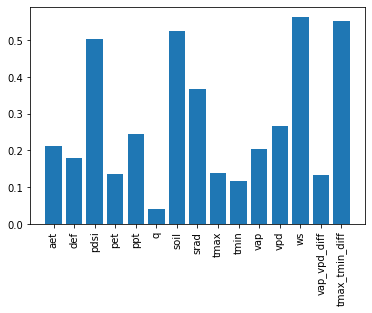

In [20]:
plt.bar(feature_columns, height=feat_imp)
plt.xticks(rotation=90)
plt.show()

In [21]:
feature_columns

['aet',
 'def',
 'pdsi',
 'pet',
 'ppt',
 'q',
 'soil',
 'srad',
 'tmax',
 'tmin',
 'vap',
 'vpd',
 'ws',
 'vap_vpd_diff',
 'tmax_tmin_diff']